<h3 style="text-align:center"> <b>Formula 1</b> Data Analysis </h3>

Version 1.0.0  
Author: [Dorian ROUX](https://rouxdorian.com)  
Estimated Runtime: < 2 minutes. 
 
---- 

#### Libraries

In [571]:
# - Import Libraries - 
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

#### Functions

In [121]:
# - Update a dictionnary - #
def updateDictionnary(inputDict: dict, outputDict: dict, inputKeys: list, outputKeys: list):
    """Update a dictionnary by adding a new key and value based on the existance of the inputKeys within the inputDict.
    Args:
        inputDict (dict): the input dictionnary.
        outputDict (dict): the output dictionnary.
        inputKeys (list): the list of keys to look for in the inputDict.
        outputKeys (list): the list of keys to add in the outputDict depending on the inputKeys.
    """    
    for i_, inputKey in enumerate(inputKeys):
        if inputKey in inputDict.keys():
            outputDict[outputKeys[i_]] = inputDict[inputKey]
    return outputDict

# - Export a dictionnary as a JSON file - #
def exportJSON(dictContent: dict, filePath: str):
    """Export a dictionnary as a JSON file.
    Args:
        dictContent (dict): the dictionary to export.
        filePath (str): the path where to export the file.
    """    
    if not os.path.exists(os.path.dirname(filePath)):
        os.makedirs(os.path.dirname(filePath), exist_ok=True)
    with open(filePath, 'w') as fp:
        json.dump(dictContent, fp, indent=4)

# - Export a DataFrame as a CSV file - #
def exportCSV(df: pd.DataFrame, filePath: str):
    """Export a DataFrame as a CSV file.
    Args:
        df (pd.DataFrame): the DataFrame to export.
        filePath (str): the path where to export the file.
    """    
    if not os.path.exists(os.path.dirname(filePath)):
        os.makedirs(os.path.dirname(filePath), exist_ok=True)
    df.to_csv(filePath, index=False)

#### Core

- Race Winners per Drivers & Constructors since 1950
- Total Wins per Drivers & Constructors since 1950

In [515]:
# Data Folder
dataFolder = '../data'
dataProcessedFolder = os.path.join(dataFolder, 'processed')
dataPrscImagesFolder = os.path.join(dataProcessedFolder, 'images')

# Load the data
dictF1 = json.load(open(os.path.join(dataFolder, 'formula1-data.json'), 'r'))

##### 1) Race Winners per Drivers & Constructors since 1950

In [230]:
df_winners = pd.DataFrame() # Initialize the output dataframe
for seasonKey in dictF1.keys():  # Loop through each F1 Season
    for raceRoundKey in dictF1[seasonKey]['RACES']: # Loop through each Season Race
        if raceRoundKey in dictF1[seasonKey]['RESULTS']: # Verify whether the Race has a result (for instance a race in the future does not have a result yet)
            raceResult = dictF1[seasonKey]['RESULTS'][raceRoundKey]
            df_race = pd.DataFrame([{'SEASON': int(seasonKey), 'ROUND': int(raceRoundKey), 
                                     'RACE_NAME': dictF1[seasonKey]['RACES'][raceRoundKey]['RACE']['NAME'], 
                                     'CONSTRUCTOR': dictF1[seasonKey]['CONSTRUCTORS'][raceResult['1']['CONSTRUCTOR_ID']]['NAME'],
                                     'WINNER':  f"{dictF1[seasonKey]['DRIVERS'][raceResult['1']['DRIVER_ID']]['FIRST_NAME']} {dictF1[seasonKey]['DRIVERS'][raceResult['1']['DRIVER_ID']]['LAST_NAME']}",
                                     'GRID_POSITION': raceResult['1']['GRID_POSITION'], 'TIME': raceResult['1']['TIME']['time'],
                                     }])
            df_winners = pd.concat([df_winners, df_race], axis=0)
df_winners = df_winners.sort_values(by=['SEASON', 'ROUND']).reset_index(drop=True)
df_winners.sample(5)

,SEASON,ROUND,RACE_NAME,CONSTRUCTOR,WINNER,GRID_POSITION,TIME
409,1985,6,Detroit Grand Prix,Williams,Keke Rosberg,5,1:55:39.851
196,1970,13,Mexican Grand Prix,Ferrari,Jacky Ickx,3,1:53:28.3
555,1994,8,British Grand Prix,Williams,Damon Hill,1,1:30:03.640
906,2014,10,German Grand Prix,Mercedes,Nico Rosberg,1,1:33:42.914
763,2006,14,Turkish Grand Prix,Ferrari,Felipe Massa,1,1:28:51.082


In [231]:
# Export the Data
pathFile = os.path.join(dataProcessedFolder, 'race-winners-drivers-constructors.csv')
exportCSV(df_winners, pathFile)

In [140]:
# Display Information
averageYear = 1990
print(f"Total Races: {df_winners.shape[0]}")
print(f"Total Seasons: {df_winners['SEASON'].nunique()}")
print(f"Average Races per Season (Before {averageYear}): {round(df_winners[df_winners['SEASON'] < averageYear].shape[0] / df_winners[df_winners['SEASON'] < averageYear]['SEASON'].nunique())}")
print(f"Average Races per Season (After {averageYear}): {round(df_winners[df_winners['SEASON'] >= averageYear].shape[0] / df_winners[df_winners['SEASON'] >= averageYear]['SEASON'].nunique())}")
print(f"Total Constructors Winners: {df_winners['CONSTRUCTOR'].nunique()}")
print(f"Total Drivers Winners: {df_winners['WINNER'].nunique()}")

Total Races: 1104
Total Seasons: 75
Average Races per Season (Before 1990): 12
Average Races per Season (After 1990): 18
Total Constructors Winners: 47
Total Drivers Winners: 111


##### 2) Total Wins per Drivers & Constructors since 1950

In [159]:
# Transform the DataFrame
df_winners.rename(columns={"WINNER": "DRIVER"}, inplace=True)
df_winners['WINS'] = df_winners.groupby('DRIVER')['DRIVER'].transform('count')
df_winners.sort_values(by=['WINS'], ascending=False, inplace=True)
df_total_wins = df_winners[['DRIVER', 'WINS']].drop_duplicates().reset_index(drop=True)

rank = 1
lsRank = []
for index, row in df_total_wins.iterrows():
    if (index > 0 and row['WINS'] != df_total_wins.iloc[index - 1]['WINS']):
        rank += 1
    lsRank.append(rank)
df_total_wins['RANK'] = lsRank
df_total_wins.head(10)

,DRIVER,WINS,RANK
0,Lewis Hamilton,103,1
1,Michael Schumacher,91,2
2,Max Verstappen,56,3
3,Sebastian Vettel,53,4
4,Alain Prost,51,5
5,Ayrton Senna,41,6
6,Fernando Alonso,32,7
7,Nigel Mansell,31,8
8,Jackie Stewart,27,9
9,Niki Lauda,25,10


Implement additionnal information like the following:
- Number of Seasons
- Number of Races
- Percentage of Wins

In [224]:
dictDrivers = {driverFullName: {'RACES': [], 'SEASONS': [], 'WINS': df_total_wins[df_total_wins.DRIVER == driverFullName].WINS.iloc[0]} for driverFullName in df_total_wins['DRIVER'].unique()}

df_drivers_races = pd.DataFrame() # Initialize the output dataframe
for seasonKey in dictF1.keys():  # Loop through each F1 Season
    for raceRoundKey in dictF1[seasonKey]['RACES']: # Loop through each Season Race
        if raceRoundKey in dictF1[seasonKey]['RESULTS']: # Verify whether the Race has a result (for instance a race in the future does not have a result yet)
            raceResult = dictF1[seasonKey]['RESULTS'][raceRoundKey]
            for driverKey in dictF1[seasonKey]['RESULTS'][raceRoundKey].keys():
                driverFullName = f"{dictF1[seasonKey]['DRIVERS'][raceResult[driverKey]['DRIVER_ID']]['FIRST_NAME']} {dictF1[seasonKey]['DRIVERS'][raceResult[driverKey]['DRIVER_ID']]['LAST_NAME']}"
                if driverFullName in dictDrivers.keys():
                    if seasonKey not in dictDrivers[driverFullName]['SEASONS']:
                        dictDrivers[driverFullName]['SEASONS'].append(seasonKey)
                    if raceRoundKey not in dictDrivers[driverFullName]['RACES']:
                        dictDrivers[driverFullName]['RACES'].append(dictF1[seasonKey]['RACES'][raceRoundKey]['RACE']['NAME'])

# Compute the SUMs
for driverFullName in dictDrivers.keys():
    dictDrivers[driverFullName]['N_RACES'] = len(dictDrivers[driverFullName]['RACES'])
    dictDrivers[driverFullName]['N_SEASONS'] = len(dictDrivers[driverFullName]['SEASONS'])

# Compute the Wins%
for driverFullName in dictDrivers.keys():
    dictDrivers[driverFullName]['WINS%'] = round((dictDrivers[driverFullName]['WINS'] / dictDrivers[driverFullName]['N_RACES']) * 100, 2)

In [225]:
df_total_wins_per_races = pd.DataFrame(dictDrivers).T
df_total_wins_per_races = df_total_wins_per_races.reset_index(names='DRIVER')[['DRIVER', 'WINS', 'N_RACES', 'N_SEASONS', 'WINS%']].sort_values(by=['WINS'], ascending=False)

Rank based on the WINS

In [236]:
basedOn = 'WINS'
rank = 1
lsRank = []
df_total_wins_per_races_by_wins = df_total_wins_per_races.copy().sort_values(by=[basedOn], ascending=False)
for index, row in df_total_wins_per_races_by_wins.iterrows():
    if (index > 0 and row[basedOn] != df_total_wins_per_races_by_wins.iloc[index - 1][basedOn]):
        rank += 1
    lsRank.append(rank)
    
df_total_wins_per_races_by_wins['RANK'] = lsRank
df_total_wins_per_races_by_wins.head(10)

,DRIVER,WINS,N_RACES,N_SEASONS,WINS%,RANK
0,Lewis Hamilton,103,335,18,30.75,1
1,Michael Schumacher,91,308,19,29.55,2
2,Max Verstappen,56,188,10,29.79,3
3,Sebastian Vettel,53,300,16,17.67,4
4,Alain Prost,51,202,13,25.25,5
5,Ayrton Senna,41,162,11,25.31,6
6,Fernando Alonso,32,383,21,8.36,7
7,Nigel Mansell,31,192,15,16.15,8
8,Jackie Stewart,27,100,9,27.0,9
9,Niki Lauda,25,174,13,14.37,10


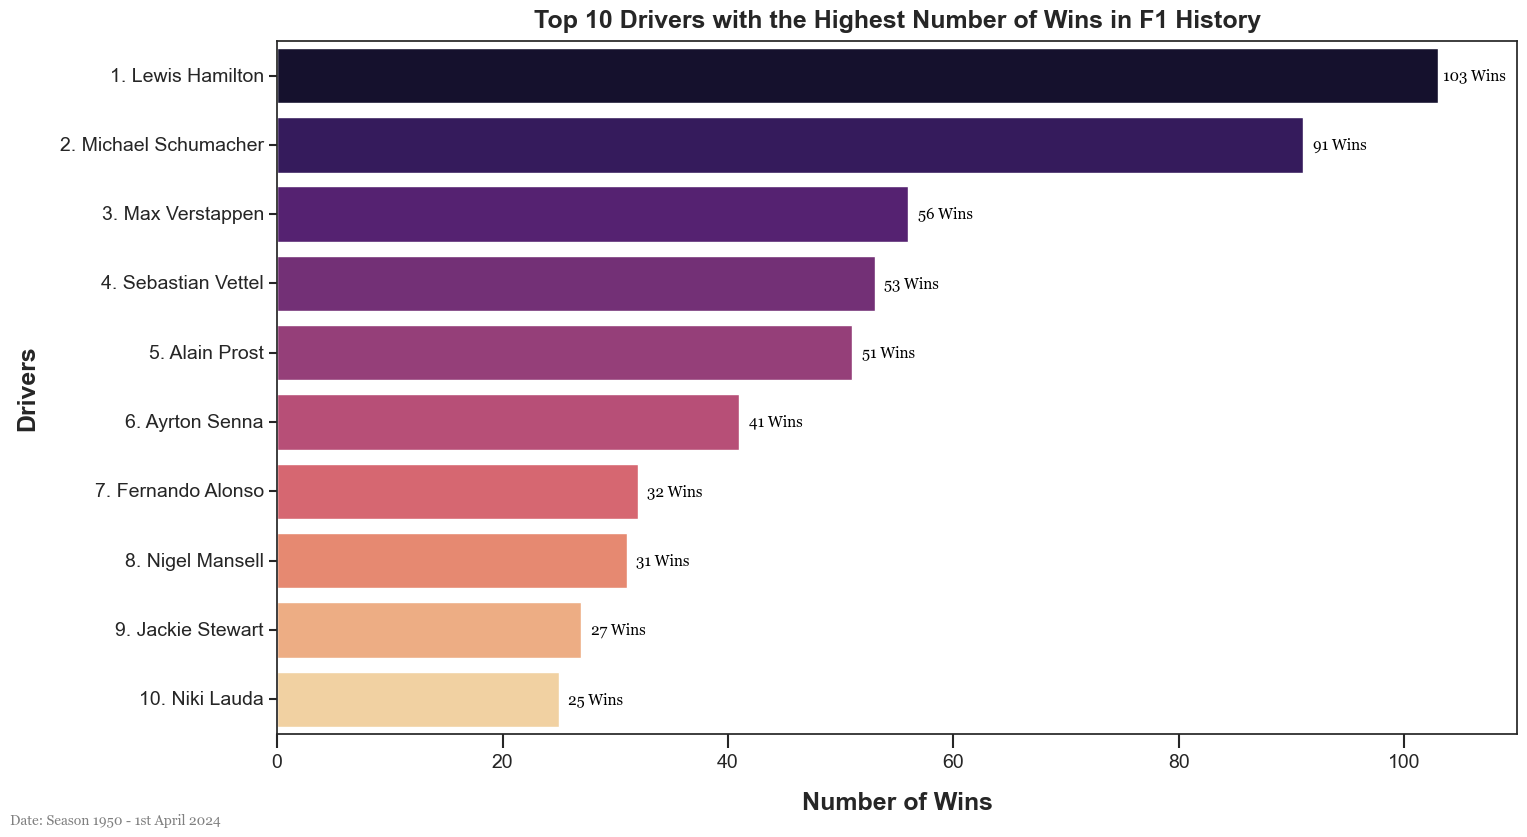

In [579]:
# Build the Figure
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.rc('font', family='Georgia')

# Build the Barplot
df = df_total_wins_per_races_by_wins.head(10).copy()
slct_palette = "magma"
ax = sns.barplot(x='WINS', y='DRIVER', data=df, palette=slct_palette)
ax.set_title('Top 10 Drivers with the Highest Number of Wins in F1 History', fontsize=18, fontweight='bold', pad=10)
ax.set_xlabel("Number of Wins", size=18, fontweight='bold', labelpad=15)
ax.set_ylabel("Drivers", size=18, fontweight='bold', labelpad=15)
ax.set_yticklabels([f"{i+1}. {value}" for i,value in enumerate(df['DRIVER'])], va='center')
ax.tick_params(axis='x', bottom=True, labelsize=14, width=1.5)
ax.tick_params(axis='y', left=True, labelsize=14, width=1.5)
plt.xlim([0, 110])

# Display the Values on the Bars
for index, row in df_total_wins_per_races_by_wins.head(10).iterrows():
    plt.text(row['WINS'] + 3.25, index + 0.05, f"{row['WINS']} Wins", color='black', ha="center", fontdict={'fontsize': 11})

# Insert Side Note
ax.text(-5, 10.8, 'Date: Season 1950 - 1st April 2024', fontsize=10, color='gray', ha='right')

# Save the Plot
os.makedirs(dataPrscImagesFolder, exist_ok=True)
plt.savefig(os.path.join(dataPrscImagesFolder, 'top-10-drivers-most-wins.png'), dpi=300, bbox_inches='tight')

# Show the Plot
plt.show()

Rank based on the WINS%

In [581]:
basedOn = 'WINS%'
rank = 1
lsRank = []
df_total_wins_per_races_by_winsprct = df_total_wins_per_races.copy().sort_values(by=[basedOn], ascending=False)
for index, row in df_total_wins_per_races_by_winsprct.iterrows():
    if (index > 0 and row[basedOn] != df_total_wins_per_races_by_winsprct.iloc[index - 1][basedOn]):
        rank += 1
    lsRank.append(rank)
    
df_total_wins_per_races_by_winsprct['RANK'] = lsRank
df_total_wins_per_races_by_winsprct.head(15)

,DRIVER,WINS,N_RACES,N_SEASONS,WINS%,RANK
100,Lee Wallard,1,2,2,50.0,2
11,Juan Fangio,24,54,8,44.44,3
67,Bill Vukovich,2,5,5,40.0,4
22,Alberto Ascari,13,34,6,38.24,5
10,Jim Clark,25,73,9,34.25,6
0,Lewis Hamilton,103,335,18,30.75,6
2,Max Verstappen,56,188,10,29.79,7
1,Michael Schumacher,91,308,19,29.55,8
8,Jackie Stewart,27,100,9,27.0,9
5,Ayrton Senna,41,162,11,25.31,10


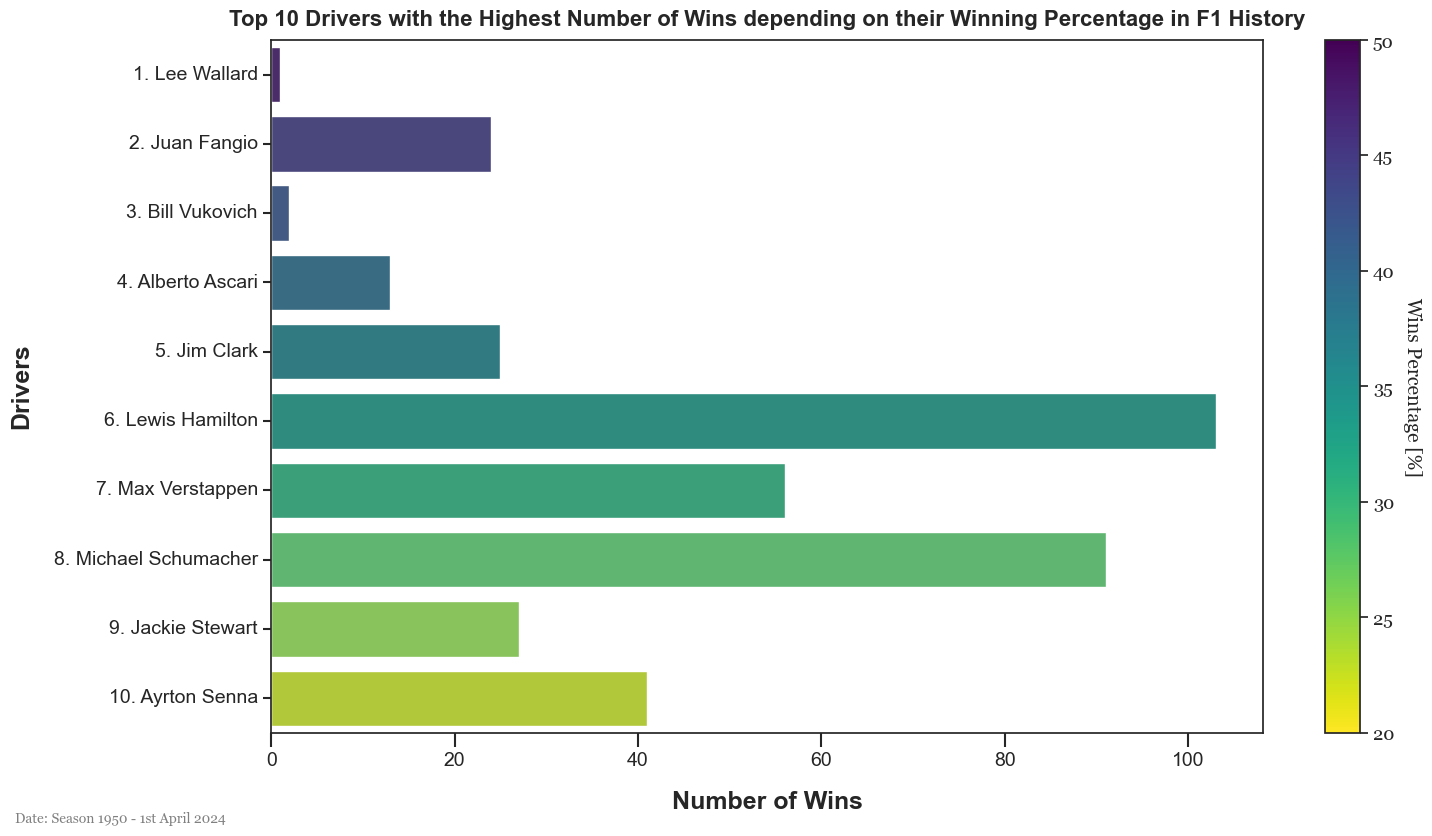

In [582]:
# Build the Figure
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.rc('font', family='Georgia')

# Build the Barplot
df = df_total_wins_per_races_by_winsprct.head(10).copy()
slct_palette = "viridis"
ax = sns.barplot(x='WINS', y='DRIVER', data=df, palette=slct_palette)
ax.set_title('Top 10 Drivers with the Highest Number of Wins depending on their Winning Percentage in F1 History', fontsize=16, fontweight='bold', pad=10)
ax.set_xlabel("Number of Wins", size=18, fontweight='bold', labelpad=15)
ax.set_ylabel("Drivers", size=18, fontweight='bold', labelpad=15)
ax.set_yticklabels([f"{i+1}. {value}" for i,value in enumerate(df['DRIVER'])], va='center')
ax.tick_params(axis='x', bottom=True, labelsize=14, width=1.5)
ax.tick_params(axis='y', left=True, labelsize=14, width=1.5)

# Insert Side Note
ax.text(-5, 10.8, 'Date: Season 1950 - 1st April 2024', fontsize=10, color='gray', ha='right')

# Insert Colorbar
norm = mcolors.Normalize(vmin=round(df['WINS%'].min() / 5) * 5 - 5, vmax=round(df['WINS%'].max() / 5) * 5)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=f"{slct_palette}_r", norm=norm), ax=ax)
cbar.set_label('Wins Percentage [%]', rotation=270, labelpad=20, fontsize=14, fontname='Georgia')

# Save the Plot
os.makedirs(dataPrscImagesFolder, exist_ok=True)
plt.savefig(os.path.join(dataPrscImagesFolder, 'top-10-drivers-best-wins-percentage.png'), dpi=300, bbox_inches='tight')

# Show the Plot
plt.show()

##### 1) Race Winners per Drivers & Constructors since 1950

Rank based on the WINS% with a Minimum of 50 Races

In [596]:
basedOn = 'WINS%' 
filterOnRaces = 50
rank = 1
lsRank = []
df_total_wins_per_races_by_winsprct_mor = df_total_wins_per_races.copy().sort_values(by=[basedOn], ascending=False)
df_total_wins_per_races_by_winsprct_mor = df_total_wins_per_races_by_winsprct_mor[df_total_wins_per_races_by_winsprct_mor['N_RACES'] >= filterOnRaces].reset_index(drop=True)

for index, row in df_total_wins_per_races_by_winsprct_mor.iterrows():
    if (index > 0 and row[basedOn] != df_total_wins_per_races_by_winsprct_mor.iloc[index - 1][basedOn]):
        rank += 1
    lsRank.append(rank)
    
df_total_wins_per_races_by_winsprct_mor['RANK'] = lsRank
df_total_wins_per_races_by_winsprct_mor.head(15)

,DRIVER,WINS,N_RACES,N_SEASONS,WINS%,RANK
0,Juan Fangio,24,54,8,44.44,1
1,Jim Clark,25,73,9,34.25,2
2,Lewis Hamilton,103,335,18,30.75,3
3,Max Verstappen,56,188,10,29.79,4
4,Michael Schumacher,91,308,19,29.55,5
5,Jackie Stewart,27,100,9,27.0,6
6,Ayrton Senna,41,162,11,25.31,7
7,Alain Prost,51,202,13,25.25,8
8,Stirling Moss,16,71,11,22.54,9
9,Damon Hill,22,122,8,18.03,10


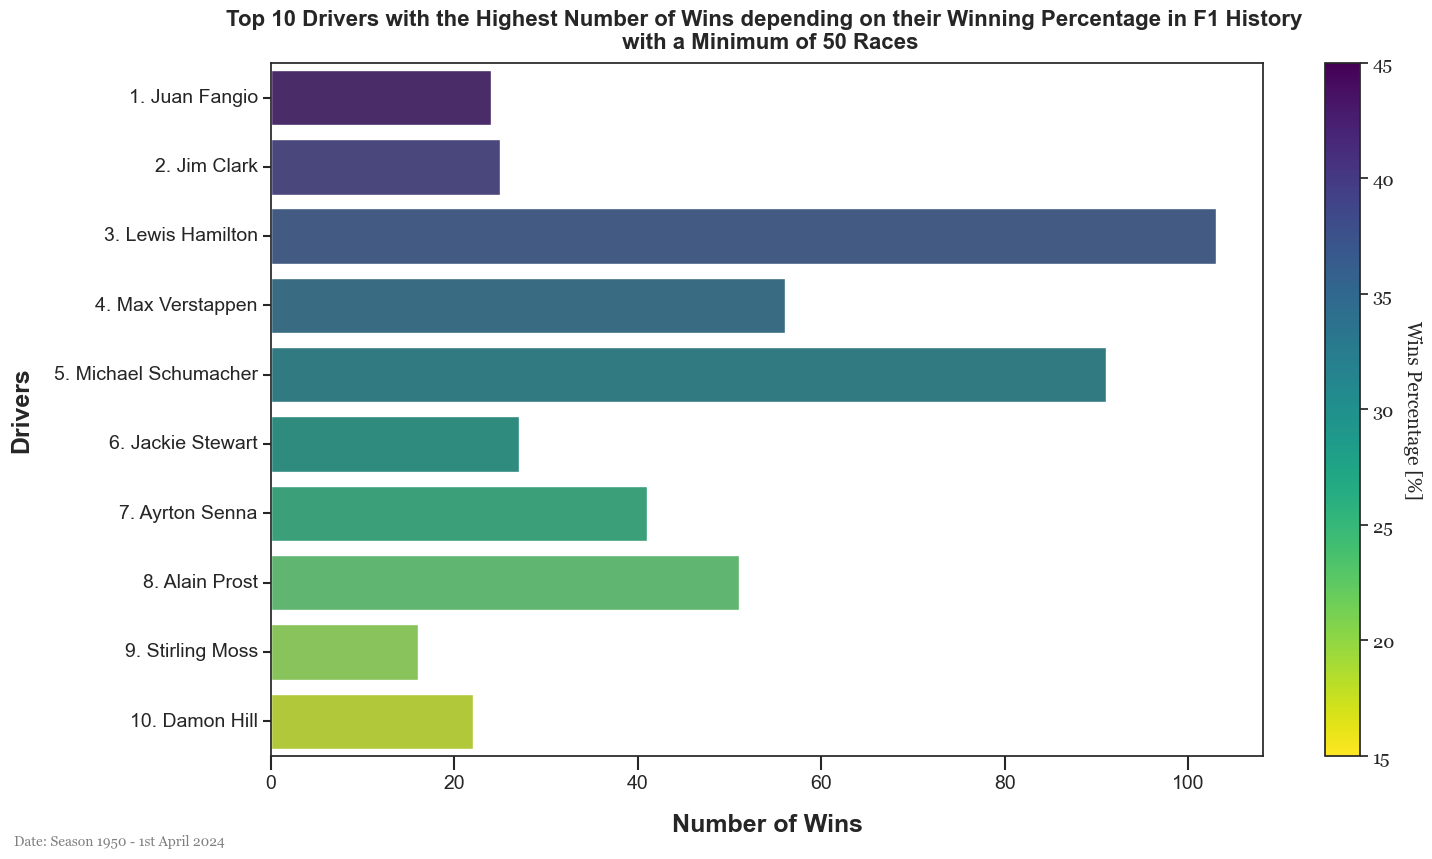

In [598]:
# Build the Figure
sns.set_style("white")
fig, ax = plt.subplots(1, 1, figsize=(16, 9))
plt.rc('font', family='Georgia')

# Build the Barplot
df = df_total_wins_per_races_by_winsprct_mor.head(10).copy()
slct_palette = "viridis"
ax = sns.barplot(x='WINS', y='DRIVER', data=df, palette=slct_palette)
ax.set_title(f'Top 10 Drivers with the Highest Number of Wins depending on their Winning Percentage in F1 History \n with a Minimum of {filterOnRaces} Races', fontsize=16, fontweight='bold', pad=10)
ax.set_xlabel("Number of Wins", size=18, fontweight='bold', labelpad=15)
ax.set_ylabel("Drivers", size=18, fontweight='bold', labelpad=15)
ax.set_yticklabels([f"{i+1}. {value}" for i,value in enumerate(df['DRIVER'])], va='center')
ax.tick_params(axis='x', bottom=True, labelsize=14, width=1.5)
ax.tick_params(axis='y', left=True, labelsize=14, width=1.5)

# Insert Side Note
ax.text(-5, 10.8, 'Date: Season 1950 - 1st April 2024', fontsize=10, color='gray', ha='right')

# Insert Colorbar
norm = mcolors.Normalize(vmin=round(df['WINS%'].min() / 5) * 5 - 5, vmax=round(df['WINS%'].max() / 5) * 5)
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=f"{slct_palette}_r", norm=norm), ax=ax)
cbar.set_label('Wins Percentage [%]', rotation=270, labelpad=20, fontsize=14, fontname='Georgia')

# Save the Plot
os.makedirs(dataPrscImagesFolder, exist_ok=True)
plt.savefig(os.path.join(dataPrscImagesFolder, f'top-10-drivers-best-wins-percentage-min{filterOnRaces}races.png'), dpi=300, bbox_inches='tight')

# Show the Plot
plt.show()

In [253]:
# Export the Data
pathFile = os.path.join(dataProcessedFolder, 'total-wins-per-driver.csv')
exportCSV(df_winners, pathFile)

pathFile = os.path.join(dataProcessedFolder, 'total-wins-per-driver-per-races.csv')
exportCSV(df_total_wins_per_races, pathFile)

pathFile = os.path.join(dataProcessedFolder, 'rank-drivers-per-wins.csv')
exportCSV(df_total_wins_per_races_by_wins, pathFile)

pathFile = os.path.join(dataProcessedFolder, 'rank-drivers-per-winsprct.csv')
exportCSV(df_total_wins_per_races_by_winsprct, pathFile)